<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

In [1]:
#!pip install pycaret[full] --user#!pip install mlflow --user

In [2]:
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user

#!pip install hyperopt --user

###### References

In [3]:
# https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.

# https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec

# https://www.dataquest.io/blog/understanding-regression-error-metrics/ 

# https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/

# https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret

# https://pycaret.readthedocs.io/en/latest/api/regression.html

# http://www.pycaret.org/tutorials/html/REG102.html

# https://githubhelp.com/ray-project/tune-sklearn



#### Libraries

In [4]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [5]:
#Receive Data
#dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\@Working\SPE_Paper'
dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
filename_suffix = 'csv'

##### Read in the data 

In [6]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()


,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,AFRICA,ABU GHARADIG,140.0,ONSHORE,232.0,4500.000000,GAS DRIVE,9350.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.10,21.0,140.00,40.5,13.810000,850.0,166.0,19.0,2
1,AFRICA,ABU GHARADIG,140.0,ONSHORE,250.0,4600.000000,GAS DRIVE,9650.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.07,16.0,140.00,40.0,4.740000,800.0,214.0,14.0,2
2,MIDDLE EAST,ZAGROS,0.0,ONSHORE,190.0,4452.278385,AQUIFER DRIVE,7500.0,20.0,NEOGENE/PALEOGENE,...,LAYER-CAKE,0.36,19.0,385.00,32.6,0.580000,950.0,57300.0,44.3,3
3,MIDDLE EAST,SOUTH OMAN SALT,62.0,ONSHORE,212.0,11600.000000,GAS DRIVE,12140.0,10.0,CAMBRIAN/PROTEROZOIC,...,LAYER-CAKE,0.68,17.0,0.01,48.0,0.135469,410.0,1321.0,7.0,4
4,EUROPE,NORTH SEA CENTRAL,0.0,OFFSHORE,172.0,2850.000000,GAS DRIVE,6102.0,1.5,PALEOGENE,...,TANK LIKE,0.80,35.0,3000.00,19.5,7.000000,246.0,1000.0,44.0,7


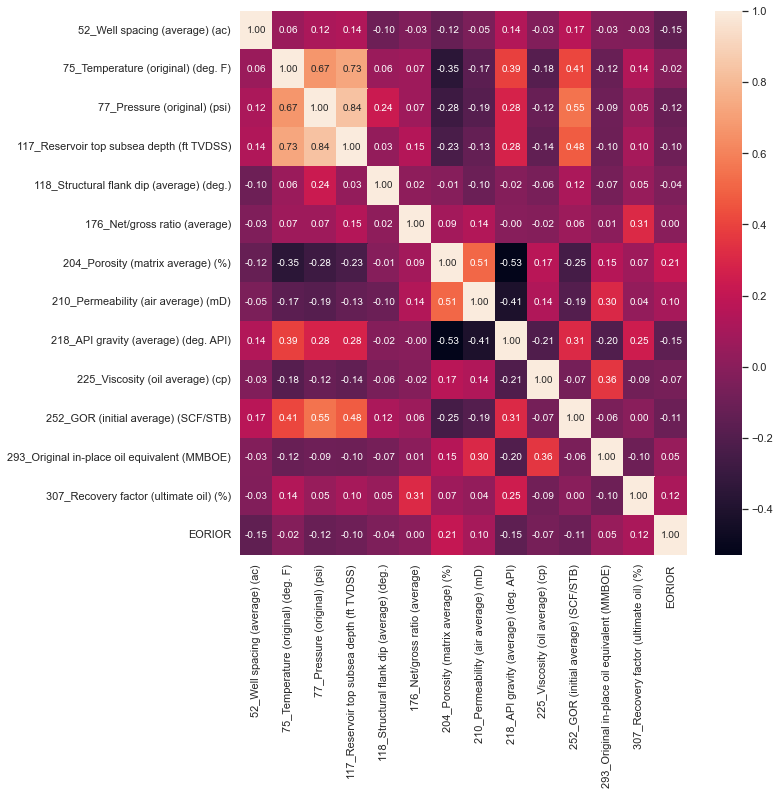

In [7]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As that the 117 variables do not add any additional information when it comes to predictive modelleing, I will drop 117 and recreate the heat map to check for correlation.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

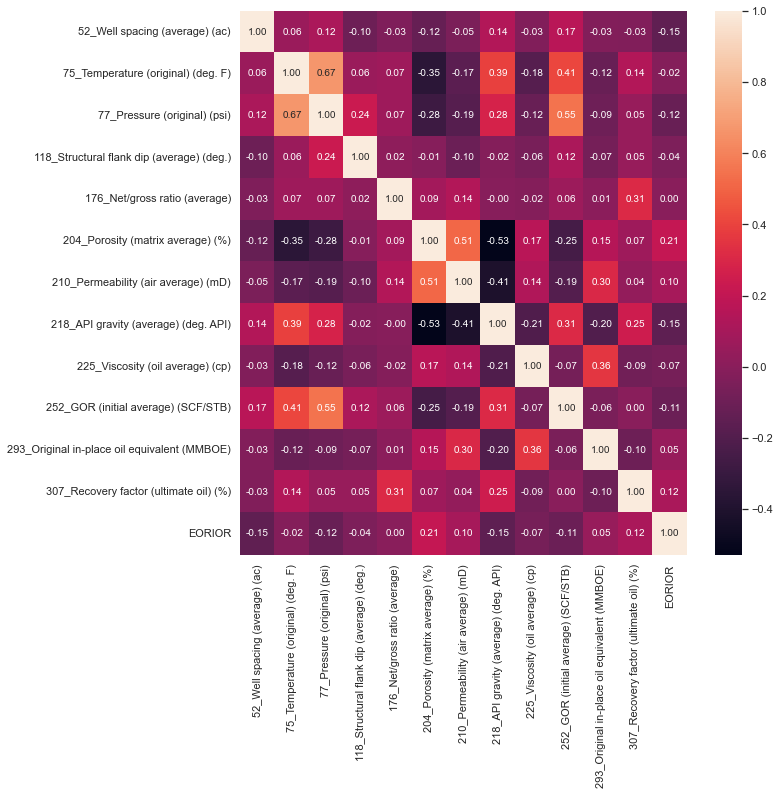

In [8]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Drop Structural Flank Dip - does not make much difference to the resutls and is a difficult input to find for other fields

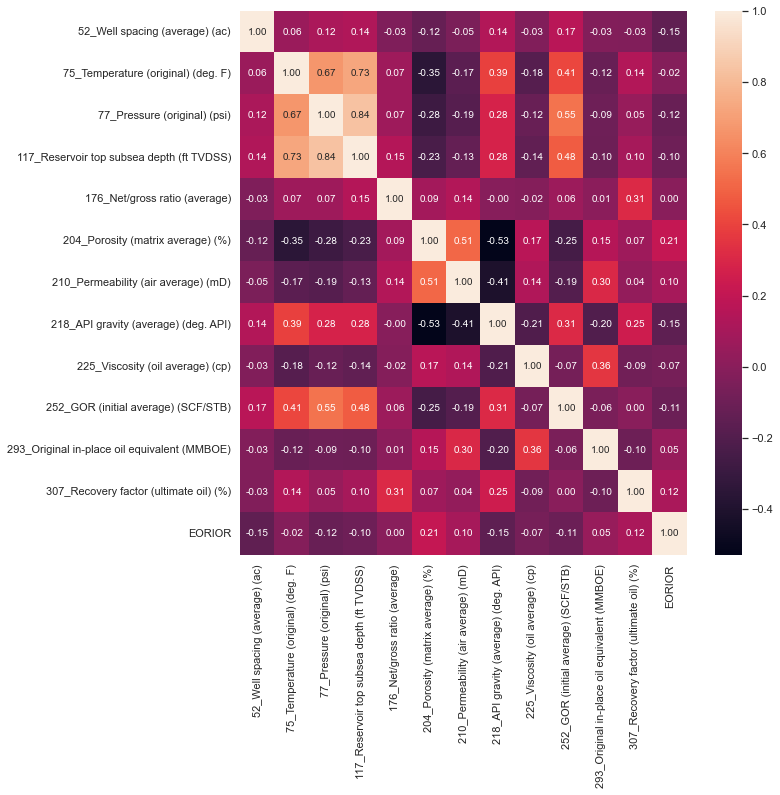

In [9]:
df_drop = df.drop(['118_Structural flank dip (average) (deg.)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Convert EORIOR to float - to ensure it is a numerical feature

In [10]:
df_drop['EORIOR'] = df_drop['EORIOR'].astype(float)

In [11]:
# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

436
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   10_Region                                     436 non-null    object 
 1   11_Basin name                                 436 non-null    object 
 2   52_Well spacing (average) (ac)                436 non-null    float64
 3   72_Onshore or offshore                        436 non-null    object 
 4   75_Temperature (original) (deg. F)            436 non-null    float64
 5   77_Pressure (original) (psi)                  436 non-null    float64
 6   82_Drive mechanism (main)                     436 non-null    object 
 7   117_Reservoir top subsea depth (ft TVDSS)     436 non-null    float64
 8   149_Reservoir period                          436 non-null    object 
 9   153_Depositional system (main)                436 non-null   

In [12]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = '307_Recovery factor (ultimate oil) (%)'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            ignore_low_variance=True,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,307_Recovery factor (ultimate oil) (%)
2,Original Data,"(436, 20)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(305, 155)"


In [13]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.9672,129.2324,11.3381,0.3965,0.3492,0.3238,0.6440
rf,Random Forest Regressor,9.3756,134.8555,11.6021,0.3702,0.3584,0.3379,0.0590
gbr,Gradient Boosting Regressor,9.5861,141.1346,11.8496,0.3378,0.3636,0.3408,0.0220
ada,AdaBoost Regressor,9.9525,144.7291,12.0102,0.3205,0.3761,0.3705,0.0220
lightgbm,Light Gradient Boosting Machine,9.8603,145.7697,12.0441,0.3174,0.3643,0.3478,0.0890
xgboost,Extreme Gradient Boosting,9.6027,147.1957,12.0923,0.3134,0.3651,0.3269,0.0890
et,Extra Trees Regressor,10.2360,162.7153,12.7235,0.2395,0.3922,0.3730,0.0560
br,Bayesian Ridge,10.7952,174.1211,13.1628,0.1911,0.4030,0.3985,0.0060
knn,K Neighbors Regressor,10.8725,175.7475,13.2074,0.1823,0.4124,0.4065,0.0080
lasso,Lasso Regression,11.1737,184.7241,13.5774,0.1399,0.4180,0.4212,0.2650


In [14]:
top3 = compare_models(include=['rf', 'gbr', 'catboost'], sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.9672,129.2324,11.3381,0.3965,0.3492,0.3238,0.6500
rf,Random Forest Regressor,9.3756,134.8555,11.6021,0.3702,0.3584,0.3379,0.0610
gbr,Gradient Boosting Regressor,9.5861,141.1346,11.8496,0.3378,0.3636,0.3408,0.0250


##### Do GBR model to check plots and features

In [15]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4104,153.2754,12.3804,0.2847,0.4288,0.4115
1,8.7113,112.9781,10.6291,0.4421,0.3174,0.2898
2,9.5156,149.9345,12.2448,0.2905,0.4192,0.4073
3,8.4374,143.9447,11.9977,0.3840,0.3465,0.2799
4,8.7449,130.1629,11.4089,0.3849,0.3205,0.2803
5,8.7023,105.3911,10.2660,0.5528,0.3699,0.3616
6,9.8293,132.2287,11.4991,0.4275,0.2951,0.2669
7,10.5478,149.8762,12.2424,0.1417,0.3587,0.3456
8,11.4519,168.9394,12.9977,0.2023,0.3705,0.3678


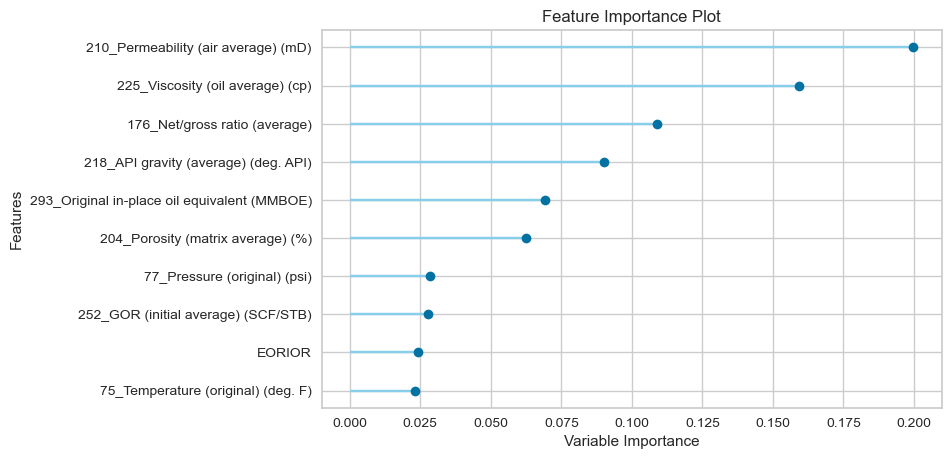

In [16]:
plot_model(gbr, plot = 'feature')

In [17]:
#evaluate_model(best)

### CatBoost

In [18]:
cb = create_model('catboost')
print(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8896,147.9652,12.1641,0.3095,0.4496,0.4446
1,7.2998,101.6228,10.0808,0.4981,0.3062,0.2536
2,9.5727,141.1975,11.8827,0.3319,0.4196,0.4127
3,9.5276,168.4759,12.9798,0.2790,0.3806,0.3266
4,8.4817,123.9670,11.1340,0.4142,0.3002,0.2597
5,8.9860,104.8694,10.2406,0.5550,0.3752,0.3781
6,8.6853,121.3164,11.0144,0.4748,0.2624,0.2217
7,9.3723,125.6651,11.2100,0.2804,0.3264,0.2996
8,9.4037,121.7663,11.0348,0.4250,0.3233,0.3100


In [19]:
tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = 50)
print(tuned_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9396,144.9999,12.0416,0.3233,0.4419,0.4354
1,8.0170,114.3744,10.6946,0.4352,0.3266,0.2844
2,9.5869,137.1741,11.7121,0.3509,0.4160,0.4218
3,8.7553,145.6615,12.0690,0.3766,0.3482,0.2949
4,8.9195,140.5438,11.8551,0.3358,0.3150,0.2714
5,9.6895,122.4270,11.0647,0.4805,0.4012,0.4129
6,8.9404,126.6397,11.2534,0.4517,0.2627,0.2236
7,9.2906,119.4234,10.9281,0.3161,0.3292,0.3088
8,9.5098,126.2777,11.2373,0.4037,0.3306,0.3203


In [20]:
tuned_cb100 = tune_model(cb, optimize = 'MSE', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.6446,139.3987,11.8067,0.3494,0.4333,0.4154
1,8.0948,112.3883,10.6013,0.4450,0.3242,0.2837
2,9.8444,140.2311,11.8419,0.3364,0.4164,0.4277
3,9.3281,155.5172,12.4707,0.3345,0.3805,0.3449
4,8.8864,135.1017,11.6233,0.3616,0.3204,0.2844
5,8.8662,109.2999,10.4547,0.5362,0.3930,0.3940
6,8.5516,117.5490,10.8420,0.4911,0.2560,0.2179
7,9.2112,114.9431,10.7211,0.3418,0.3296,0.3128
8,9.8044,130.1236,11.4072,0.3856,0.3343,0.3202


In [21]:
#evaluate_model(cb)

In [22]:
#tuned_cb1 = tune_model(cb, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=10)
#print(tuned_cb1)

In [23]:
#tuned_cb2 = tune_model(cb, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=10)
#print(tuned_cb2)

In [24]:
tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 50)
print(tuned_cb3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9396,144.9999,12.0416,0.3233,0.4419,0.4354
1,8.0170,114.3744,10.6946,0.4352,0.3266,0.2844
2,9.5869,137.1741,11.7121,0.3509,0.4160,0.4218
3,8.7553,145.6615,12.0690,0.3766,0.3482,0.2949
4,8.9195,140.5438,11.8551,0.3358,0.3150,0.2714
5,9.6895,122.4270,11.0647,0.4805,0.4012,0.4129
6,8.9404,126.6397,11.2534,0.4517,0.2627,0.2236
7,9.2906,119.4234,10.9281,0.3161,0.3292,0.3088
8,9.5098,126.2777,11.2373,0.4037,0.3306,0.3203


In [25]:
tuned_cb4 = tune_model(cb, optimize = 'RMSE', n_iter = 10)
print(tuned_cb4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.1127,169.6709,13.0258,0.2082,0.4434,0.4331
1,8.0267,116.6089,10.7986,0.4241,0.3249,0.2823
2,11.0808,193.9688,13.9273,0.0822,0.4976,0.4436
3,8.0554,134.0863,11.5796,0.4262,0.3312,0.2589
4,9.8878,148.6503,12.1922,0.2975,0.3371,0.3127
5,8.8091,101.8674,10.0929,0.5677,0.3350,0.3280
6,8.2870,116.8614,10.8102,0.4941,0.2575,0.2130
7,10.1668,134.7783,11.6094,0.2282,0.3358,0.3204
8,9.9646,142.7132,11.9463,0.3261,0.3467,0.3233


In [26]:
bagged_cb = ensemble_model(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9376,148.4302,12.1832,0.3073,0.4478,0.4394
1,8.6308,124.2230,11.1455,0.3865,0.3352,0.3006
2,9.5596,141.5996,11.8996,0.3300,0.4192,0.4241
3,9.2196,151.2289,12.2975,0.3528,0.3730,0.3331
4,9.0009,141.3390,11.8886,0.3321,0.3278,0.2876
5,9.2569,110.1177,10.4937,0.5327,0.3919,0.3997
6,9.1281,124.3267,11.1502,0.4618,0.2648,0.2349
7,9.5409,126.7502,11.2583,0.2742,0.3314,0.3104
8,9.6544,126.8944,11.2647,0.4008,0.3322,0.3258


In [27]:
boosted_cb = ensemble_model(cb, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.7421,146.4968,12.1036,0.3163,0.4471,0.4360
1,8.3304,123.7189,11.1229,0.3890,0.3346,0.2926
2,9.2630,133.2916,11.5452,0.3693,0.4120,0.4134
3,8.6758,137.1809,11.7124,0.4129,0.3518,0.3120
4,8.4859,127.1577,11.2764,0.3991,0.3122,0.2693
5,9.2000,111.1386,10.5422,0.5284,0.3853,0.3909
6,9.1394,122.8610,11.0843,0.4681,0.2647,0.2356
7,9.1522,119.3786,10.9261,0.3164,0.3278,0.2975
8,9.5607,123.9040,11.1312,0.4149,0.3224,0.3090


In [28]:
#tuned_bagged_cb = tune_model(cb, ensemble = True, method = 'Bagging', n_iter = 100)
#tuned_bagged_cb = tune_model(cb, ensemble = True, method = 'Bagging', n_iter = 100)

### Random Forest

In [29]:
rf = create_model('rf')
print(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.5517,141.6475,11.9016,0.3390,0.4272,0.4213
1,8.8703,130.2031,11.4107,0.3570,0.3287,0.2896
2,9.6936,139.5750,11.8142,0.3396,0.4195,0.4277
3,9.0030,139.9059,11.8282,0.4013,0.3637,0.3318
4,8.7880,130.2185,11.4113,0.3846,0.3149,0.2779
5,9.5944,119.5880,10.9356,0.4925,0.3901,0.3987
6,9.1295,135.9602,11.6602,0.4114,0.2771,0.2288
7,8.7731,116.3716,10.7876,0.3336,0.3231,0.2913
8,10.8662,160.0253,12.6501,0.2444,0.3663,0.3546


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [30]:
tuned_rf = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=50)
print(tuned_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.7445,151.6822,12.3159,0.2921,0.4439,0.4452
1,9.4482,135.3690,11.6348,0.3315,0.3393,0.3115
2,9.8693,145.5666,12.0651,0.3112,0.4239,0.4350
3,9.0566,136.3269,11.6759,0.4166,0.3597,0.3334
4,9.1004,142.2347,11.9262,0.3278,0.3233,0.2859
5,9.2225,113.1618,10.6378,0.5198,0.3860,0.3887
6,9.5206,130.5018,11.4237,0.4350,0.2701,0.2406
7,9.2890,125.5022,11.2028,0.2813,0.3383,0.3135
8,10.8133,154.8118,12.4423,0.2690,0.3544,0.3510


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=0.5350019248668697,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0012082496573154258,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=183, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [31]:
tuned_rf1 = tune_model(rf, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
print(tuned_rf1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.8379,151.7131,12.3172,0.2920,0.4449,0.4451
1,8.6300,130.3823,11.4185,0.3561,0.3157,0.2649
2,9.5843,144.8024,12.0334,0.3148,0.4281,0.4326
3,8.1283,117.8982,10.8581,0.4955,0.3319,0.2908
4,8.8804,136.7873,11.6956,0.3536,0.3230,0.2833
5,9.4681,119.9704,10.9531,0.4909,0.3892,0.3970
6,8.6476,128.4944,11.3355,0.4437,0.2661,0.2082
7,9.3518,131.7025,11.4762,0.2458,0.3443,0.3136
8,11.0376,156.6420,12.5157,0.2603,0.3638,0.3625


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=0.43597422309777156,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=3.7867181358624816e-05,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=188, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [32]:
tuned_rf2 = tune_model(rf, optimize="MSE", n_iter=50)
print(tuned_rf2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.9029,154.8976,12.4458,0.2771,0.4498,0.4548
1,9.5269,145.5312,12.0636,0.2813,0.3493,0.3150
2,10.1970,152.2737,12.3399,0.2795,0.4324,0.4470
3,8.9987,142.5431,11.9391,0.3900,0.3706,0.3410
4,8.9666,134.6342,11.6032,0.3638,0.3165,0.2794
5,9.4013,115.5255,10.7483,0.5098,0.3842,0.3918
6,8.8157,121.8585,11.0390,0.4724,0.2601,0.2196
7,9.0211,122.0159,11.0461,0.3013,0.3289,0.2987
8,11.2352,168.8499,12.9942,0.2027,0.3686,0.3566


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=290, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [33]:
tuned_rf3 = tune_model(rf,optimize="RMSE", n_iter=50)
print(tuned_rf3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.9029,154.8976,12.4458,0.2771,0.4498,0.4548
1,9.5269,145.5312,12.0636,0.2813,0.3493,0.3150
2,10.1970,152.2737,12.3399,0.2795,0.4324,0.4470
3,8.9987,142.5431,11.9391,0.3900,0.3706,0.3410
4,8.9666,134.6342,11.6032,0.3638,0.3165,0.2794
5,9.4013,115.5255,10.7483,0.5098,0.3842,0.3918
6,8.8157,121.8585,11.0390,0.4724,0.2601,0.2196
7,9.0211,122.0159,11.0461,0.3013,0.3289,0.2987
8,11.2352,168.8499,12.9942,0.2027,0.3686,0.3566


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=290, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


### Gradient Boostsing Regression

In [34]:
gbr = create_model('gbr')
print(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4104,153.2754,12.3804,0.2847,0.4288,0.4115
1,8.7113,112.9781,10.6291,0.4421,0.3174,0.2898
2,9.5156,149.9345,12.2448,0.2905,0.4192,0.4073
3,8.4374,143.9447,11.9977,0.3840,0.3465,0.2799
4,8.7449,130.1629,11.4089,0.3849,0.3205,0.2803
5,8.7023,105.3911,10.2660,0.5528,0.3699,0.3616
6,9.8293,132.2287,11.4991,0.4275,0.2951,0.2669
7,10.5478,149.8762,12.2424,0.1417,0.3587,0.3456
8,11.4519,168.9394,12.9977,0.2023,0.3705,0.3678


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [35]:
tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="MSE", n_iter=50)
print(tuned_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.2821,149.1428,12.2124,0.3040,0.4434,0.4371
1,8.3350,97.9013,9.8945,0.5165,0.2888,0.2664
2,9.8939,161.8067,12.7203,0.2344,0.4320,0.4089
3,8.9468,138.6340,11.7743,0.4067,0.3493,0.3120
4,8.9371,133.7872,11.5666,0.3678,0.3103,0.2687
5,9.0465,106.7180,10.3304,0.5472,0.3636,0.3652
6,9.1041,126.3344,11.2399,0.4531,0.2810,0.2440
7,9.4283,123.0425,11.0925,0.2954,0.3336,0.2995
8,9.2680,117.0259,10.8179,0.4474,0.3148,0.2995


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.029935588473052315,
                          loss='ls', max_depth=5,
                          max_features=0.4498816248275211, max_leaf_nodes=None,
                          min_impurity_decrease=6.09462390229809e-06,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=9, min_weight_fraction_leaf=0.0,
                          n_estimators=188, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.2524270954927133, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [36]:
tuned_gbr1 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
print(tuned_gbr1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.2297,149.2756,12.2178,0.3034,0.4437,0.4372
1,8.5397,117.4986,10.8397,0.4197,0.3162,0.2826
2,9.3561,145.5015,12.0624,0.3115,0.4070,0.4023
3,8.1954,127.3166,11.2835,0.4551,0.3432,0.2944
4,8.8004,138.6626,11.7755,0.3447,0.3216,0.2777
5,9.6018,117.7531,10.8514,0.5003,0.3750,0.3823
6,9.0854,126.0578,11.2275,0.4543,0.2702,0.2287
7,8.6060,108.0476,10.3946,0.3813,0.3226,0.2787
8,10.3082,147.2654,12.1353,0.3046,0.3508,0.3300


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.03891745681716713,
                          loss='ls', max_depth=8,
                          max_features=0.7579480903822141, max_leaf_nodes=None,
                          min_impurity_decrease=0.0012937670461165185,
                          min_impurity_split=None, min_samples_leaf=2,
                          min_samples_split=3, min_weight_fraction_leaf=0.0,
                          n_estimators=92, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.5579746228449186, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [37]:
tuned_gbr2 = tune_model(gbr, optimize="MSE", n_iter=50)
print(tuned_gbr2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.7323,161.7293,12.7173,0.2452,0.4605,0.4684
1,8.0426,105.3440,10.2637,0.4798,0.2954,0.2566
2,9.5748,149.6905,12.2348,0.2917,0.4224,0.4252
3,9.3667,150.5433,12.2696,0.3557,0.3602,0.3170
4,8.5600,127.1946,11.2781,0.3989,0.3011,0.2596
5,8.8736,111.2711,10.5485,0.5278,0.3878,0.3838
6,9.0489,120.3329,10.9696,0.4790,0.2662,0.2354
7,9.6859,122.0498,11.0476,0.3011,0.3438,0.3137
8,9.3145,119.3607,10.9252,0.4364,0.3305,0.3170


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=11, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.02,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=240, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=0.55,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)


In [38]:
tuned_gbr3 = tune_model(gbr, optimize="RMSE", n_iter=50)
print(tuned_gbr3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.7323,161.7293,12.7173,0.2452,0.4605,0.4684
1,8.0426,105.3440,10.2637,0.4798,0.2954,0.2566
2,9.5748,149.6905,12.2348,0.2917,0.4224,0.4252
3,9.3667,150.5433,12.2696,0.3557,0.3602,0.3170
4,8.5600,127.1946,11.2781,0.3989,0.3011,0.2596
5,8.8736,111.2711,10.5485,0.5278,0.3878,0.3838
6,9.0489,120.3329,10.9696,0.4790,0.2662,0.2354
7,9.6859,122.0498,11.0476,0.3011,0.3438,0.3137
8,9.3145,119.3607,10.9252,0.4364,0.3305,0.3170


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=11, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.02,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=240, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=0.55,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)


In [39]:
tuned_gbr4 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="optuna", optimize="RMSE", n_iter=50)
print(tuned_gbr4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4814,171.6512,13.1016,0.1989,0.4745,0.4817
1,8.7552,117.6033,10.8445,0.4192,0.3143,0.2835
2,9.6018,139.4282,11.8080,0.3402,0.4027,0.4017
3,9.4420,155.7367,12.4795,0.3335,0.3694,0.3282
4,8.6884,126.9621,11.2677,0.4000,0.3041,0.2685
5,9.0237,108.7011,10.4260,0.5387,0.3653,0.3656
6,9.6767,143.9744,11.9989,0.3767,0.2888,0.2531
7,9.0127,108.8830,10.4347,0.3765,0.3159,0.2943
8,9.0990,113.7482,10.6653,0.4629,0.3130,0.2967


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.022032170899022773,
                          loss='ls', max_depth=7,
                          max_features=0.49160302318155347, max_leaf_nodes=None,
                          min_impurity_decrease=4.1448921809792405e-05,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=4, min_weight_fraction_leaf=0.0,
                          n_estimators=211, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.2628279699109589, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [40]:
tuned_gbr5 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="bayesian", optimize="RMSE", n_iter=50)
print(tuned_gbr5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.3149,128.2808,11.3261,0.4013,0.4263,0.4143
1,7.6322,98.2466,9.9119,0.5148,0.2892,0.2425
2,9.0479,128.1961,11.3224,0.3934,0.4022,0.4017
3,7.9022,116.8237,10.8085,0.5001,0.3130,0.2670
4,8.4075,122.6501,11.0748,0.4204,0.3036,0.2619
5,8.6916,103.4883,10.1729,0.5609,0.3650,0.3646
6,8.6992,117.2962,10.8303,0.4922,0.2590,0.2194
7,8.6563,113.3614,10.6471,0.3508,0.3436,0.2678
8,11.1114,170.0661,13.0409,0.1970,0.3938,0.3799


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.06486450334606676,
                          loss='ls', max_depth=8,
                          max_features=0.6356161909623536, max_leaf_nodes=None,
                          min_impurity_decrease=2.2305886799428185e-07,
                          min_impurity_split=None, min_samples_leaf=2,
                          min_samples_split=4, min_weight_fraction_leaf=0.0,
                          n_estimators=157, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.44039574808512, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


### BLENDING ALL MODELS

In [41]:
blend_all = blend_models(estimator_list = [cb,rf,gbr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9064,141.9247,11.9132,0.3377,0.4322,0.4171
1,8.1451,108.7197,10.4269,0.4631,0.3103,0.2733
2,9.4029,138.2368,11.7574,0.3459,0.4127,0.4107
3,8.7992,145.6962,12.0705,0.3765,0.3575,0.3071
4,8.5154,123.7188,11.1229,0.4153,0.3076,0.2679
5,8.9774,106.1396,10.3024,0.5496,0.3761,0.3771
6,9.1320,125.7337,11.2131,0.4557,0.2728,0.2370
7,9.4742,126.5358,11.2488,0.2754,0.3328,0.3097
8,10.5174,146.3353,12.0969,0.3090,0.3497,0.3424


### Stacking Models

In [42]:
stack_1 = stack_models([cb,rf,gbr], meta_model = cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.7992,149.7433,12.2370,0.3012,0.4311,0.4125
1,8.6373,116.7484,10.8050,0.4234,0.3350,0.3041
2,9.9049,150.2249,12.2566,0.2892,0.4256,0.4032
3,9.6612,177.8125,13.3346,0.2390,0.3864,0.3087
4,7.7332,101.3155,10.0656,0.5212,0.2829,0.2435
5,8.7202,91.9332,9.5882,0.6099,0.3335,0.3326
6,9.2044,143.8460,11.9936,0.3773,0.2937,0.2345
7,9.6985,138.5165,11.7693,0.2068,0.3435,0.3109
8,9.8835,127.1468,11.2759,0.3996,0.3344,0.3304


### The best most is using the GBR Regressor tuned to RMSE using bayesian

In [43]:
tuned_gbr5

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.06486450334606676,
                          loss='ls', max_depth=8,
                          max_features=0.6356161909623536, max_leaf_nodes=None,
                          min_impurity_decrease=2.2305886799428185e-07,
                          min_impurity_split=None, min_samples_leaf=2,
                          min_samples_split=4, min_weight_fraction_leaf=0.0,
                          n_estimators=157, n_iter_no_change=None,
                          presort='deprecated', random_state=42,
                          subsample=0.44039574808512, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

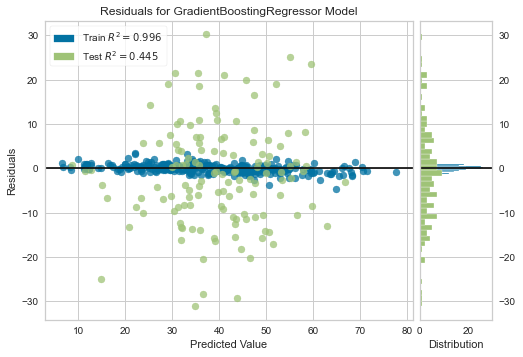

In [44]:
plot_model(tuned_gbr5)

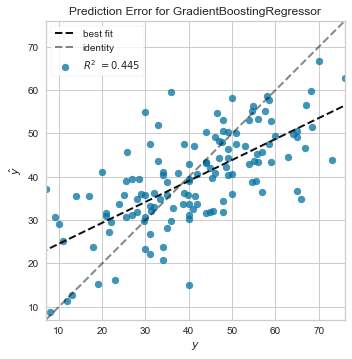

In [45]:
plot_model(tuned_gbr5, plot = 'error')

In [46]:
#https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
plot_model(tuned_gbr5, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

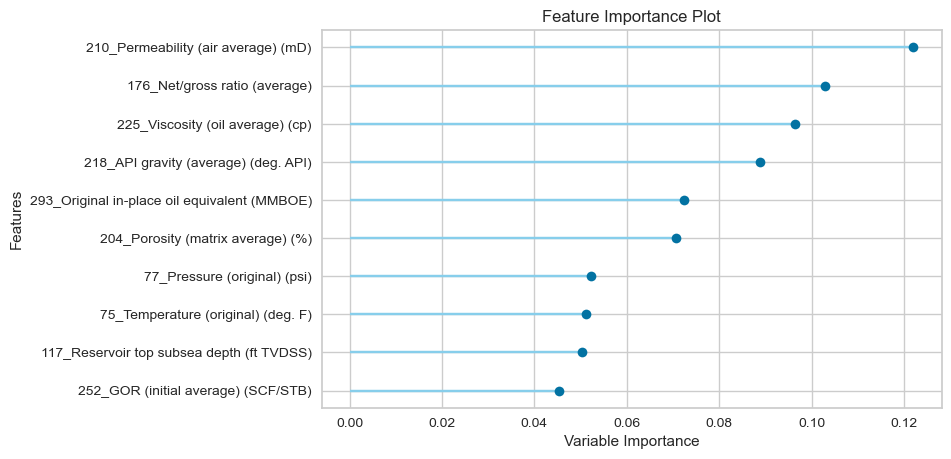

In [50]:
plot_model(tuned_gbr5, plot = 'feature')

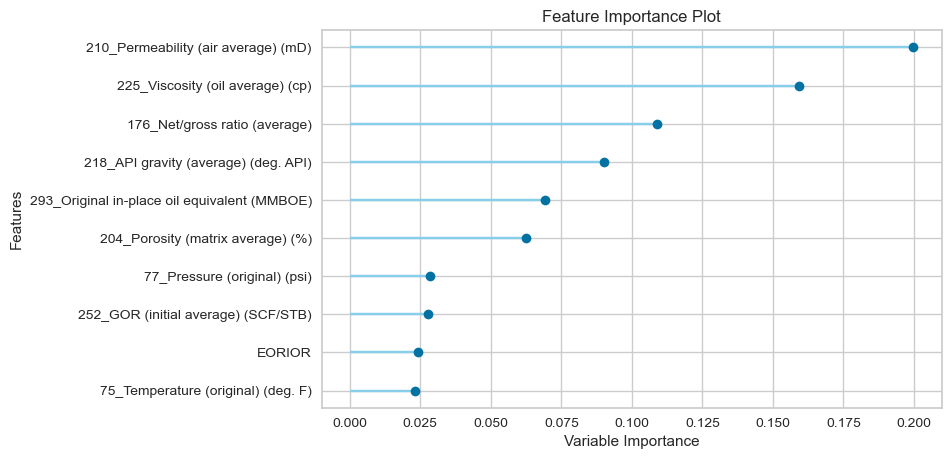

In [49]:
plot_model(gbr, plot = 'feature')

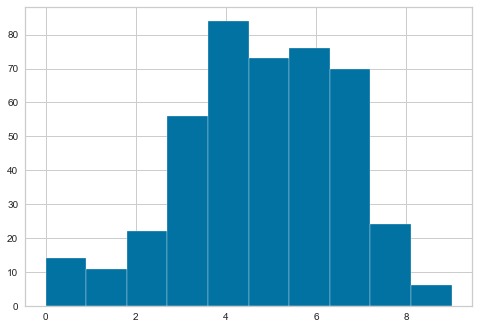

In [51]:
df_drop['EORIOR'].hist()

In [54]:
df_drop['EORIOR'].describe()

count    436.000000
mean       4.853211
std        1.971408
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        9.000000
Name: EORIOR, dtype: float64

In [57]:
df_drop['EORIOR'].value_counts()

4.0    84
6.0    76
5.0    73
7.0    70
3.0    56
8.0    24
2.0    22
0.0    14
1.0    11
9.0     6
Name: EORIOR, dtype: int64

In [58]:
df_drop['10_Region'].value_counts()

NORTH AMERICA          101
ASIA-PACIFIC            99
EUROPE                  74
LATIN AMERICA           61
FORMER SOVIET UNION     46
AFRICA                  37
MIDDLE EAST             18
Name: 10_Region, dtype: int64

In [59]:
df_drop['11_Basin name'].value_counts()

NORTH SEA CENTRAL      27
NORTH SEA NORTHERN     27
WESTERN CANADA         22
SIBERIAN WESTERN       21
BOHAI                  20
                       ..
AZOV-KUBAN              1
CHACO                   1
WESSEX                  1
CENTRAL OMAN UPLIFT     1
RECONCAVO               1
Name: 11_Basin name, Length: 111, dtype: int64

In [60]:
df_drop['11_Basin name'].nunique()

111

In [61]:
df_drop['82_Drive mechanism (main)'].value_counts()

AQUIFER DRIVE       245
GAS DRIVE           179
COMPACTION            8
GRAVITY DRAINAGE      4
Name: 82_Drive mechanism (main), dtype: int64

In [62]:
df_drop['149_Reservoir period'].value_counts()

CRETACEOUS                                124
NEOGENE                                    98
PALEOGENE                                  77
JURASSIC                                   53
TRIASSIC                                   12
NEOGENE/PALEOGENE                          12
PERMIAN                                     9
CARBONIFEROUS                               9
PERMIAN/CARBONIFEROUS                       7
DEVONIAN                                    7
JURASSIC/TRIASSIC                           7
ORDOVICIAN/CAMBRIAN                         4
CAMBRIAN                                    3
CRETACEOUS/JURASSIC                         2
PALEOGENE/CRETACEOUS                        2
TRIASSIC/CARBONIFEROUS                      2
PROTEROZOIC                                 2
NEOGENE/PALEOGENE/CRETACEOUS                1
CRETACEOUS/TRIASSIC/PALEOZOIC               1
CAMBRIAN/PROTEROZOIC                        1
CRETACEOUS/JURASSIC/TRIASSIC/PALEOZOIC      1
CARBONIFEROUS/DEVONIAN            

In [63]:
df_drop['153_Depositional system (main)'].value_counts()

24:COASTAL        199
21:FLUVIAL        101
25:DEEP MARINE     85
23:LACUSTRINE      35
22:DESERT          13
26:GLACIOGENIC      3
Name: 153_Depositional system (main), dtype: int64

In [64]:
df_drop['161_Reservoir architecture (main)'].value_counts()

LAYER-CAKE                  261
JIGSAW-PUZZLE               132
LABYRINTH                    29
TANK LIKE                     9
JIGSAW-PUZZLE/LAYER-CAKE      2
LAYER-CAKE/TANK LIKE          2
JIGSAW-PUZZLE/LABYRINTH       1
Name: 161_Reservoir architecture (main), dtype: int64

In [65]:
df_drop['EORIOR'].value_counts()

4.0    84
6.0    76
5.0    73
7.0    70
3.0    56
8.0    24
2.0    22
0.0    14
1.0    11
9.0     6
Name: EORIOR, dtype: int64

In [67]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,Former Soviet Union,Siberien Western,119,Onshore,138,3756,Gas Drive,8544.4,0,Cretaceous,...,Labyrinth,0.59,0.18,100,40,1,580,490,NaN,4


In [71]:
BlindPredict = predict_model(tuned_gbr5, data=dfblind, round=0)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0,0,0,0,0,0


In [72]:
BlindPredict

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR,Label
0,Former Soviet Union,Siberien Western,119,Onshore,138,3756,Gas Drive,8544.4,0,Cretaceous,...,0.59,0.18,100,40,1,580,490,NaN,4,23.524125
